In [9]:
# Generic OpenAI-compatible endpoint using ChatOpenAI
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage
from IPython.display import Image, display

import os
default_model_name = os.environ["OPENAI_MODEL"]
pg_connection = os.environ["PGVECTOR_CONNECTION_STRING"]
llm = ChatOpenAI(model=default_model_name,temperature=0)

In [10]:
def print_messages(result, last_n=None):
    """
    Fungsi untuk menampilkan pesan.
    Jika last_n diisi (misal: 2), hanya menampilkan n pesan terakhir.
    """
    messages = result.get("messages", [])
    
    # Jika last_n diberikan, kita slice list-nya (misal: messages[-2:])
    if last_n is not None:
        messages = messages[-last_n:]
    
    for msg in messages:
        if "type" in msg:
            role = "😎 USER" if msg.type == "human" else "🤖 BOT"
            print(f"{role}: {msg.content}")

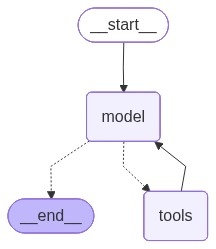

In [11]:
import ast
from typing import Annotated, TypedDict

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool

from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

import operator
import re

@tool
def calculator(query: str) -> str:
    """Alat kalkulator sederhana. Masukan harus berupa ekspresi matematika."""
    # Hanya izinkan angka, operator matematika, dan spasi
    if not re.match(r'^[0-9+\-*/(). ]+$', query):
        raise ValueError("Ekspresi hanya boleh mengandung angka dan operator matematika (+, -, *, /, ., ()")
    
    try:
        # Evaluasi ekspresi matematika dengan aman
        # Membatasi operasi hanya ke operator matematika dasar
        allowed_operators = {
            ast.Add: operator.add,
            ast.Sub: operator.sub,
            ast.Mult: operator.mul,
            ast.Div: operator.truediv,
            ast.USub: operator.neg,
            ast.UAdd: operator.pos,
        }

        def eval_math_expr(node):
            if isinstance(node, ast.Constant):  # Angka
                return node.value
            elif isinstance(node, ast.Num):  # Untuk Python versi lama
                return node.n
            elif isinstance(node, ast.BinOp):  # Operasi biner
                left = eval_math_expr(node.left)
                right = eval_math_expr(node.right)
                return allowed_operators[type(node.op)](left, right)
            elif isinstance(node, ast.UnaryOp):  # Operasi unary
                operand = eval_math_expr(node.operand)
                return allowed_operators[type(node.op)](operand)
            else:
                raise TypeError(f"Operasi tidak dikenal: {type(node)}")

        node = ast.parse(query, mode='eval').body
        result = eval_math_expr(node)
        
        # Konversi hasil ke string
        if isinstance(result, float) and result.is_integer():
            return str(int(result))
        return str(result)
    except Exception as e:
        raise ValueError(f"Ekspresi matematika tidak valid: {str(e)}")

search = DuckDuckGoSearchRun()
tools = [search, calculator]
model = ChatOpenAI(model=default_model_name,temperature=0.1).bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

def model_node(state: State) -> State:
    res = model.invoke(state["messages"])
    return {"messages": res}

builder = StateGraph(State)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()
png_bytes =graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))

In [24]:
input = {
    "messages": [
        HumanMessage("""  blackpink  members age while last tsunami hits aceh ? use tools""")
    ]
}
for c in graph.stream(input):
    print(c)

{'model': {'messages': AIMessage(content='To determine the ages of Blackpink members when the last tsunami hit Aceh, I need to follow these steps:\n\n1. Identify the date of the last tsunami that hit Aceh. \n2. Find the birthdates of the Blackpink members.\n3. Calculate the ages of the members based on the date of the tsunami.\n\nFirst, I will search for the date of the last tsunami that hit Aceh.\n', additional_kwargs={'tool_calls': [{'id': 'call_adea022d47b74c4db16ada56', 'function': {'arguments': '{"query": "last tsunami hit Aceh date"}', 'name': 'duckduckgo_search'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 111, 'prompt_tokens': 400, 'total_tokens': 511, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 256}}, 'model_name': 'qwen3-coder-plus', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-94db417e-78a3-4554-abb9-67ce8af50ffb-0'

c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:61: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:62: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'tools': {'messages': [ToolMessage(content='last的用法及短语和搭配一、用作形容词用作形容词，意为“最后的”“最近过去的”等，注意：1. 与 morning, afternoon, night 等搭配，注意其表达习惯：正：yesterday morning 昨天早上 误：last morning正：yest 表示“上一个”的时候last作为名词使用， 表示“最后的”的时候last作为形容词使用。 last 英 [lɑːst] 美 [læst] 1、n. 末尾，最后；上个； 鞋楦 （做鞋的模型） 2、adj. 最后的；最近的，最新的；仅剩的；最不可 … last用法中总共有6种词性，2种核心意思: 最后的，持续 当我们学习一般过去时时会用到last， I visited Beijing last week. 我上周去了北京。 此处的last表示上一次，前一次的意思。 May 8, 2024 · last和the last的区别在于它们的用途和上下文中的具体含义。 首先，在一般的语境中，“last”常常用作形容词或副词，表示“最后的”或“最近过去的”。例如，当我们说“I read the last … 当last加名词时，怎么判断它表示“前一个的”还是“最后一个的”？ 为啥last day表示最后一天，而last month就表示上个月？ 不表示最后一个月？ 那the last page到底是“最后一页”还是“上一页”? 显示全 …', name='duckduckgo_search', id='da57224e-aeea-4646-aadc-590f4a4a1224', tool_call_id='call_adea022d47b74c4db16ada56')]}}
{'model': {'messages': AIMessage(content='The last major tsunami that hit Aceh occurred on December 26, 2004. Now that we have the date of the tsunami, I will proceed to find the birthdates of the Blackpink members and calculate th